# 線形回帰（教師有り学習）

ここから始まるレクチャーでは、線形回帰について学びます。
scikit-learnを使って、線形回帰のモデルを作り、新しいデータを使った予測を試みます。
サンプルデータは、アメリカの大都市ボストンの住宅価格です。初めは、1つだけの変数を使った単回帰をやってみます。

線形回帰の数学的な背景に興味がある場合は、以下のサイトが参考になります。
- [wikipedia（日本語）](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0)
- [wikipedia（英語）](http://en.wikipedia.org/wiki/Linear_regression) 
- Andrew Ngの動画（英語）もあります [youtube](https://www.youtube.com/watch?v=5u4G23_OohI).

4回に分かれているレクチャーの概要です。

    Step 1: データの準備
    Step 2: ひとまず可視化
    Step 3: 最小二乗法の数学的な背景
    Step 4: Numpyを使った単回帰
    Step 5: 誤差について
    Step 6: scikit-learnを使った重回帰分析
    Step 7: 学習（Training）と検証（Validation）
    Step 8: 価格の予測
    Step 9 : 残差プロット
    

### Step 1: データの準備

scikit-learnに用意されているサンプルデータを使います。

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

データを読み込むために、次のモジュールをimortします。

In [3]:
from sklearn.datasets import load_boston

In [7]:
# 住宅価格サンプルデータのロード
boston = load_boston()

データの概要をみてみましょう。

In [8]:
# Descriptionは説明です。
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Step 2: ひとまず可視化

未知のデータを入手したときは、データを可視化して、その概要を確認するのは重要です。

Text(0,0.5,'Number of houses')

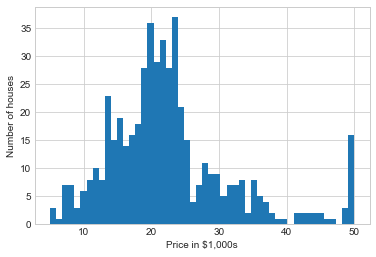

In [9]:
# 価格のヒストグラムです。 (これがモデルを作って、最終的に予測したい値です。）
plt.hist(boston.target,bins=50)

plt.xlabel('Price in $1,000s')
plt.ylabel('Number of houses')

今度は散布図を描いてみます。
部屋の数と価格の関係を見てみましょう。

Text(0.5,0,'Number of rooms')

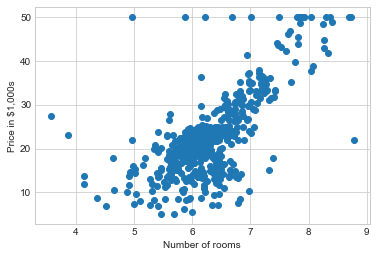

In [10]:
# ラベルがRMになっている5番目の列が、部屋の数です。
plt.scatter(boston.data[:,5],boston.target)

plt.ylabel('Price in $1,000s')
plt.xlabel('Number of rooms')

予想通り、部屋数が増えれば、価格は上がります。
ここで、pandas.DataFrameとseabornを導入します。

In [11]:
# DataFrameを作ります。
boston_df = DataFrame(boston.data)

# 列名をつけます。
boston_df.columns = boston.feature_names

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


DataFrameに新しい列を作って、目的変数（価格）を格納しておきます。

In [12]:
boston_df['Price'] = boston.target

ひとまず完成です。

In [13]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


seabornのlmplotを思い出してみましょう。回帰直線を簡単に描くことができました。

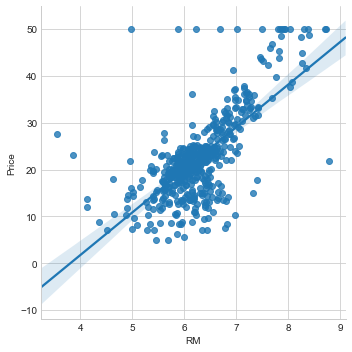

In [14]:
# lmplotを使って、回帰直線を引きます。
sns.lmplot('RM','Price',data = boston_df)

数学的に複雑なモデルが欲しいときは、これでは少し力不足なので、scikit-learnの使い方を学ぶ事にします。

<hr>

### Step 3: 最小二乗法の数学的な背景

回帰直線の係数を求めるのに使われる、「最小二乗法」について、すこし数学的になりますが、その背景を説明します。

回帰直線は、データ全体にうまく適合するように、描かれています。各点から、回帰直線への距離をDとしてみましょう。このDを最小にすれば良いわけです。このイメージを図にしてみます。

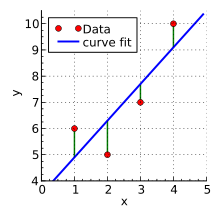

In [15]:
# wikipediaから拝借します。
from IPython.display import Image
url = 'http://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/220px-Linear_least_squares_example2.svg.png'
Image(url)

各点（赤）の座標は、(x, y)です。ここから、回帰直線（青線）への距離をDとすると、以下の値を最小にする直線が一番よさそうです。

$$ d = D_{1}^2 + D_{2}^2 + D_{3}^2 + D_{4}^2 + ....+ D_{N}^2$$

直線の式は、

$$y=ax+b$$

で表現されます。いま、$a$と$b$を求めたいのですが、これはdを最小にする$a$と$b$を見つけ出すという問題と同じです。

この問題はもちろん、手で計算することで解くことができますが、ここではこの計算をNumpyやscikit-leranにお任せします。
もし数学的な計算方法に興味がある方は、[こちら](http://mathtrain.jp/seikiequ)が大変参考になります。

### Step 4: Numpyを使った単回帰

Numpyは線形代数のライブラリの一部に、最小二乗法を解く関数を持っています。
まずはこれを使って、単回帰(説明変数が1つ）をやってみます。その後、scikit-learnを使って、重回帰（説明変数が複数）に進んで行きましょう。

入力として、2つのarray（XとY）を用意します。

Yは目的変数なので1次元のarrayですが、Xは2次元のarrayで、行がサンプル、列が説明変数です。単回帰の場合は、列が1つになりますですので、そのshapeは、(506,1)です。これを作るには、いくつか方法がありますが、ここでは、vstackを使ってみます。

In [38]:
# 部屋数
X = boston_df.RM
print(X.shape)
# これを2次元のarrayにします。
X = np.vstack(boston_df.RM)
print(X.shape)

(506,)
(506, 1)


In [34]:
Y = boston_df.Price
print(Y.shape)

(506,)


numpyで単回帰をするには、ここから、少しだけ工夫が必要です。

直線の式は、
$$y=ax+b$$
これは、次のように書き直すことができます。
$$y=Ap$$
ただし:
$$A = \begin{bmatrix}x & 1\end{bmatrix}$$

$$p= \begin{bmatrix}a \\b\end{bmatrix}$$

Aとpはベクトルで、これらの内積で直線の式を表現しただけです。
データをこの形式に変更する必要があるので、次のようなコードを実行します。

In [39]:
# Xを[X 1]の形にします。
X = np.array( [ [value,1] for value in X ] )


これで準備完了

In [42]:
# 最小二乗法の計算を実行します。
a, b = np.linalg.lstsq(X, Y)[0]


求められた直線をプロットしてみましょう。

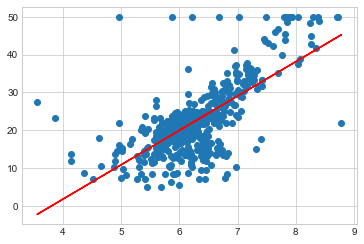

In [43]:
# まずは元のデータをプロットします。
plt.plot(boston_df.RM,boston_df.Price,'o')

# 求めた回帰直線を描きます。
x= boston_df.RM
plt.plot(x, a*x + b,'r')

<hr>

### Step 5: 誤差について

Pythonを使って、最小二乗法を用いて、単回帰を実行出来ました。
すべてのデータが完全に乗る直線を描くことは出来ませんので、どうしても誤差が出ます。

最小化しているのは、誤差の2乗和でした。ですので、全体の誤差が分かれば、それをサンプルの数で割って、平方根をとることで、ちょうど標準偏差のようなイメージで、平均誤差を計算できます。

[numpy.linalg.lstsqのドキュメント（英語）](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)

In [49]:
# 結果のarrayを取得します。
result = np.linalg.lstsq(X,Y)

In [50]:
# 2つ目の要素に、誤差の合計が入っています。
error_total = result[1]

# 誤差の平均値の平方根を計算します。
rmse = np.sqrt(error_total/len(X) )

print('平均二乗誤差の平方根は、{:0.2f}'.format(rmse[0]))

平均二乗誤差の平方根は、6.60


平均二乗誤差は、標準偏差に対応するので、95%の確率で、この値の2倍(13.2)以上誤差が広がることは無いと結論付けあれます。
正規分布の性質を思い出したい方は、[こちらを参照](http://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

### Step 6:  scikit-learnを使った重回帰分析

それでは、重回帰へと話を進めましょう。
説明変数が1つだけだと単回帰ですが、重回帰は複数の説明変数を同時に扱うことができます。

scikit-learnの線形回帰ライブラリを利用します。
[linear regression library](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

sklearn.linear_model.LinearRegressionクラスは、データを元にモデルを作り、予測値を返すことができます。
モデルを作る時には、fit()メソッドを呼び、予測をするときは、predict()メソッドを使います。
今回は重回帰モデルを使いますが、他のモデルも同じように、fitとpredictメソッドを実装しているところが、scikit-learnの便利なところです。

In [55]:
import sklearn
from sklearn.linear_model import LinearRegression

まず、LinearRegressionクラスのインスタンスを作ります。

In [56]:
lreg = LinearRegression()

lreg.fit() はデータを元にモデルを作ります。

lreg.predict() は作られたモデルを元に、予測値を返します。

lreg.score()は、決定係数を返します。
決定係数は、説明変数でどれくらいうまく目的変数の値を説明出来ているかの指標になります。[Wikipediaへのリンク](https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0)

ボストンの住宅価格を、目的変数と説明変数に分けます。

In [52]:
# 説明変数
X_multi = boston_df.drop('Price',1)

# 目的変数
Y_target = boston_df.Price

準備完了です。

In [57]:
# モデルを作ります。
lreg.fit(X_multi,Y_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

切片の値を見てみます。

In [59]:
print('切片の値は{:0.2f}'.format(lreg.intercept_))

切片の値は36.49


In [60]:
print('係数の数は{}個'.format(len(lreg.coef_)))

係数の数は13個


単回帰の時は、直線だったので、係数aと切片bはともに1つでした。今は、切片は1つですが、係数が13個あります。これは13個変数がある式になっている事を意味しています。

$$ y = b + a_1 x_1 + a_2 x_2 + \dots + a_{13} x_{13} $$

実際に求められた係数を見ていきましょう。

In [61]:
# 新しいDataFrameを作ります。
coeff_df = DataFrame(boston_df.columns)
coeff_df.columns = ['Features']

#求められた係数を代入します。
coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

coeff_df

,Features,Coefficient Estimate
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


部屋の数（RM）の係数が一番大きいことが分かります。

<hr>

### Step 7: 学習（Training）と検証（Validation）

ここまではすべてのデータを使って来ましたが、一部のデータを使って、モデルを作り、残りのデータを使って、モデルを検証するということができます。

サンプルをどのように分けるかが問題ですが、scikit-learnに便利な関数 train_test_split があるので、使って見ましょう。

サンプルを学習用のtrainと検証用のtestに分けてくれます。追加のパラメータを渡せば、割合も調整できます。
[詳しくはこちら](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)

In [74]:
# 説明変数をX、目的変数をYとして受け取ります。
from sklearn.model_selection import train_test_split
# test_size = 0.3などを指定するば、割合を指定できる、defaultは0.25のようです。
X_train, X_test, Y_train, Y_test = train_test_split(X_multi,Y_target, test_size = 0.4)

In [69]:
# どんな感じに分かれたか、確認してみます。
# train_test_split(X_multi,Y_target, test_size = 0.3)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(354, 13) (152, 13) (354,) (152,)


### Step 8: 価格の予測

それでは、学習用のデータを使ってモデルを作り、残りのデータを使って、住宅価格を予測してみましょう。

In [75]:
# まずはインスタンスを作ります。
lreg = LinearRegression()

# fitでモデルを作りますが、使うのは学習用のデータだけです。
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

予測を、学習用のデータと、テスト用のデータ、両方でやってみましょう。

In [76]:
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

それぞれの平均二乗誤差を計算できます。

In [77]:
print('X_trainを使ったモデルの平均二乗誤差＝{:0.2f}'.format(np.mean((Y_train - pred_train) ** 2)))
    
print('X_testを使ったモデルの平均二乗誤差＝{:0.2f}'.format(np.mean((Y_test - pred_test) ** 2)))

X_trainを使ったモデルの平均二乗誤差＝23.76
X_testを使ったモデルの平均二乗誤差＝20.71


サンプルの選び方を変えると、この数値も変わります。

### Step 9 : 残差プロット

回帰分析では、実際に観測された値と、モデルが予測した値の差を、残差と呼びます。

$$ 残差 = 観測された値 - 予測された値 $$

横軸に予測値、縦軸に実際の値との差をプロットしたものを、残差プロットと呼びます。

残差プロットを描いて、多くのデータがy=0の直線に近いところに集まれば、よいモデルが出来たことがわかります。
また、均一に点がプロットされている場合、線形回帰が適切だったことが分かります。そうでは無い場合は、非線形なモデルを使うことを検討しましょう。（これは後のレクチャーで解説します。）

Text(0.5,1,'Residual Plots')

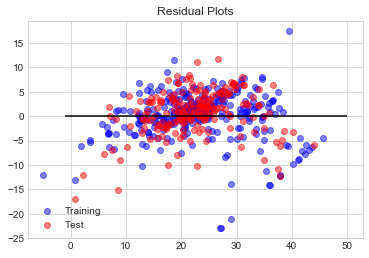

In [79]:
# 学習用のデータの残差プロットです。
train = plt.scatter(pred_train,(pred_train-Y_train),c='b',alpha=0.5)

# テスト用のデータの残差プロットです。
test = plt.scatter(pred_test,(pred_test-Y_test),c='r',alpha=0.5)

# y=0の水平な線を描いておきます。
plt.hlines(y=0,xmin=-1.0,xmax=50)

plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')

y=0の回りに、残差がランダムにばらけているように見えますので、モデルは良かったと言えそうです。右下に直線上に並んだデータに関して調べて見るのは、興味深いかもしれません。

英語になってしまいますが、scikit-learnのドキュメントには有用な情報が沢山あります。是非チェックしてみてください。
http://scikit-learn.org/stable/modules/linear_model.html#linear-model